# 10 - Count Model Data

These notes come from my reading of Washington - Statistical and Econometric Methods for Transportation Data Chapter 10.  Additional annotations throughout, but purely speculative stuff is in *italics*.  Code is my own.

In [2]:
# Preamble.
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

## 10.1 - Poisson Regression

### Definition

Poisson PDF:

$$
P(y_i) = \frac{\exp{(-\lambda_i)}\lambda_i^{y_i}}{y_i!}
$$

which is eg. the probability of of intersection $i$ having $y_i$ collisions per year. $\lambda_i$ is the **Poisson parameter**, and is the expected number of events:

$$
E[y_i] = \lambda_i
$$

Models parameterize $\lambda_i$, usually using the log-linear model:

$$
\lambda_i = \exp{(\vec{\beta}\cdot\vec{X}_i)}
$$

This also means $E[y_i] = \exp{(\vec{\beta}\cdot\vec{X}_i)}$, so the parameterization sets the expected rate.

### MLE Optimization

To optimize for $\vec{\beta}$, use the standard log-likelihood formulation:

\begin{eqnarray}
L(\vec{\beta}) &=& \prod_i \frac{\exp{(\exp{(\vec{\beta}\cdot\vec{X}_i)})}\exp{(\vec{\beta}\cdot\vec{X}_i)}^{y_i}}{y_i!} \\
\ln(L) &=& \sum_i \left(-\exp{(\vec{\beta}\cdot\vec{X}_i)} + y_i \vec{\beta}\cdot\vec{X}_i - \ln(y_i!) \right)
\end{eqnarray}

### Elasticity

Once a model is fit, we can calculate *elasticities*, estimates of impact of a single exogenous variable $x_{k}$ for observation $i$:

$$
E_{x_{ik}}^{\lambda_i} = \frac{x_{ik}}{\lambda_i}\partial_{x_{ik}}\lambda_i = \beta_k x_{ik}
$$

Note the elasticity is definitionally different for different observations, since it's defined as a fixed fractional increase of the exogenous variable.

For ordinal variables, the partial derivative $\partial_{x_{ik}}\lambda_i$ is undefined, so we instead use the pseudo-elasticity

$$
E_{x_{ik}}^{\lambda_i} = \frac{\exp(\beta_k) - 1)}{\exp(\beta_k)}
$$

## 10.2 - Poisson Goodness-of-Fit Tests

### Likelihood Ratio

Generally useful test (see [here](https://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html) for logistic regression version), which tests the likelihood of a set of model weights $\vec{\beta}_U$ (U for "unrestricted") against a "reduced model" $\vec{\beta}_R$ with fewer model parameters (or equivalently most or all weights set to zero).

$$
X^2 = -2\left( \ln(L(\vec{\beta}_R)) - \ln(L(\vec{\beta}_U)\right)
$$

The `-2` comes from [Wilks's theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem), and makes it so that $X^2$ is Chi-square distributed with degree of freedom equal to the difference between the number of free parameters in the restricted vs. unrestricted models.  This method can thus be used for hypothesis testing on why

See also the [Pearson and deviance statistics](https://online.stat.psu.edu/stat501/lesson/15/15.4), which are also Chi-square distributed.

The sum of model deviances $G^2$ is equal to zero for a model with perfect fit, but since predicted expected value $\hat{\lambda}_i$ is continuous but counts are not, a perfect fit is impossible.

$$
G^2 = 2\sum_i y_i \ln\left(\frac{y_i}{\hat{\lambda}_i}\right)
$$

*I figure this might be more useful in the signal-dominated high $\lambda$ regime. Recall that for large $\lambda$ we can approximate the Poisson as a Gaussian with mean $\lambda$ and standard deviation $\sqrt{\lambda}$, so some Poisson regression scenarios may have high signal-to-noise.*

An equivalent to [**coefficient of determination**](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ doesn't exist because the conditional mean is nonlinear and regression is heteroscedastic.  An equivalent measure is

$$
R_p^2 = 1 - \frac{\sum_i \left((y_i - \hat{\lambda}_i) / \sqrt{\hat{\lambda}_i}\right)^2}{\sum_i \left((y_i - \bar{y}) / \sqrt{\bar{y}}\right)^2}
$$

The $\rho^2$ statistic, $\rho^2 = 1 - \ln{(L(\vec{\beta}))} / \ln{(L(\vec{\beta}))}$, is another way to measure fit error.  Under ideal circumstances, every outcome is perfectly predicted, leading to $\ln{(L(\vec{\beta}))} = 0$.

$G^2$, $R_p^2$ are only meaningful when compared to scores for other models.

## 10.3 - Right-Truncated Poisson Regression

For cases where the exogenous variable is bounded, i.e. $y_i \in [0, y_\mathrm{max}]$, we can modify the Poisson distribution by capping it at $y_\mathrm{max}$ and replacing the normalization coefficient $\exp{(-\lambda_i)}$ with $\sum_0^{y_\mathrm{max}} 
\lambda_i^{y_i} / y_i!$.

## 10.4 - Negative Binomial Regression

The Poisson RV's variance is fixed to its mean, a property often not seen in empirical distributions.  In practice if $E[y_i] > Var[y_i]$, the distribution is *overdispersed*; if $E[y_i] < Var[y_i]$ it is *underdispersed*. This is often because variables influencing the Poisson rate are omitted from the regression.

The negative binomial model replaces $\lambda_i = \exp{(\vec{\beta}\cdot\vec{X}_i)}$ with

$$
\lambda_i = \exp{(\vec{\beta}\cdot\vec{X}_i + \epsilon_i)}
$$

where $\exp{(\epsilon_i)}$ is a [Gamma-distributed RV](https://en.wikipedia.org/wiki/Gamma_distribution).  This means

$$
Var[y_i] = E[y_i] + \alpha E[y_i]^2
$$

and as $\alpha \rightarrow 0$, the distribution tends toward a Poisson one (see discussion in alternate formulation).

The functional form is

$$
P(y_i) = \frac{\Gamma((1/\alpha) + y_i)}{\Gamma(1/\alpha)y_i!}\left(\frac{1/\alpha}{(1/\alpha) + \lambda_i}\right)^{1/\alpha}\left(\frac{\lambda_i}{(1/\alpha) + \lambda_i}\right)^{y_i}
$$

where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).  The corresponding likelihood function is

$$
L(\lambda_i) = \prod_i \frac{\Gamma((1/\alpha) + y_i)}{\Gamma(1/\alpha)y_i!}\left(\frac{1/\alpha}{(1/\alpha) + \lambda_i}\right)^{1/\alpha}\left(\frac{\lambda_i}{(1/\alpha) + \lambda_i}\right)^{y_i}
$$

A **test for overdispersion** (Cameron and Trivedi 1990) assumes:

\begin{eqnarray}
H_0: Var[y_i] &=& E[y_i] \\
H_A: Var[y_i] &=& E[y_i] + \alpha g(E[y_i])
\end{eqnarray}

where (typically) $g(f) = f$ or $g(f) = f^2$.  To conduct the test, create variables

\begin{eqnarray}
Z_i &=& \frac{(y_i - E[y_i])^2 - y_i}{E[y_i]\sqrt{2}} \\
W_i &=& \frac{g(E[y_i])}{\sqrt{2}}
\end{eqnarray}

then run the regression $Z_i = aW_i$, and check if $a$ is statistically significant in either case for $g(f)$.  If it is, then $H_0$ is rejected for the associated $g$.

### *Alternate Formulation*

*Here's an alternate formulation of the negative binomial distribution - given a Bernoulli experiment with success probability $p$, the negative binomial distribution is the PMF for the number of independent trials required to accumulate $n$ successes subtracted by $n$ itself.  The lower bound is zero (since we need at least $n$ trials for $n$ successes).*

*Scipy's [docs](https://docs.scipy.org/doc/scipy/reference/tutorial/stats/discrete_nbinom.html) and [Wikipedia](https://en.wikipedia.org/wiki/Negative_binomial_distribution) define the PMF as:*

$$
f(k|p, r) = {k + r - 1 \choose k}p^r(1 -  p)^k,\,\,k = 0, 1, 2,...
$$

*This can be [reformulated](https://en.wikipedia.org/wiki/Negative_binomial_distribution) as the equation above:*

$$
f(k|p, r) = \frac{\Gamma(k + r)}{k!\Gamma(r)}(1 - p)^r p^k
$$

*Here $k = y_i$, $p = \lambda_i / (1 / \alpha + \lambda_i)$ and $r = 1 / \alpha$.  Recall that the binomial RV [approaches the Poisson one](https://en.wikipedia.org/wiki/Poisson_limit_theorem) if $p \rightarrow 0$ and $n \rightarrow \infty$ such that $n p \rightarrow \lambda_i$.  Here we make a similar formulation by noting that the PMF can be rewritten as:*

$$
f(k|p, r) = \frac{r}{k + r}{k + r \choose k}p^r(1 -  p)^k,\,\,k = 0, 1, 2,...
$$

*Now, take $r = 1 / \alpha \rightarrow \infty$, and $p \rightarrow 0$ such that $(k + r)p \rightarrow \lambda$ ($k$ doesn't matter here since $kp \rightarrow 0$).  Given these conditions $r / (k + r) \rightarrow 1$, so when $r$ goes to infinity we approach the Poisson distribution.*

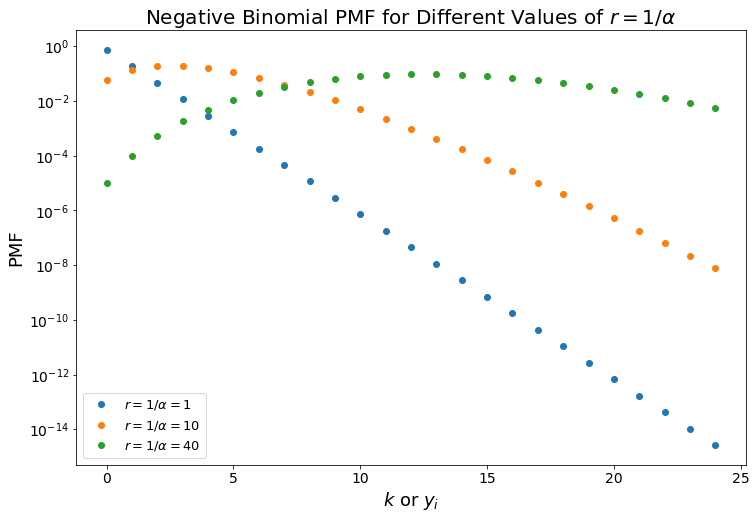

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogy(sps.nbinom.pmf(np.arange(25), 1, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha =1$')
ax.semilogy(sps.nbinom.pmf(np.arange(25), 10, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha=10$')
ax.semilogy(sps.nbinom.pmf(np.arange(25), 40, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha=40$')
ax.set_xlabel('$k$ or $y_i$', fontsize=18)
ax.set_ylabel('PMF', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=3, prop={'size': 13})
ax.set_title(r"Negative Binomial PMF for Different Values of $r = 1 / \alpha$", fontsize=20);

## 10.5 - Zero-Inflated Poisson and Negative Binomial Regression Models

Zero-inflated versions of Poisson and negative binomial are useful when there is a distinct zero-state to the system on top of the "normal-state" of Poisson or negative binomial.  This can be absolutely zero (eg. a commuter may not take public transit today, or may never take public transit - the two states both have zero value, but are distinct) or effectively zero (eg. multilane highways have very, very few pedestrian collisions).  If we were to treat the zero-state and normal-state with only a normal-state distribution, we'd find the data overdispersed.

